# Image Data Preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")

# import some common libraries
import numpy as np
import pandas as pd
import json
from tqdm.notebook import tqdm

# utilities
from pprint import pprint # For beautiful print!
from collections import OrderedDict
import os

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import cv2

# For reading annotations file
from pycocotools.coco import COCO

## Load data

In [2]:
# load the data from the archive folder and show some examples
TRAIN_ANNOTATIONS_PATH = "../bigdata/train/annotations.json"
TRAIN_IMAGE_DIRECTIORY = "../bigdata/train/images/"

VAL_ANNOTATIONS_PATH = "../bigdata/val/annotations.json"
VAL_IMAGE_DIRECTIORY = "../bigdata/val/images/"

train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=1.34s)
creating index...
index created!


In [3]:
# Reading the annotation files
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
  val_annotations_data = json.load(f)

In [4]:
train_annotations_data['annotations'][0]

{'id': 184135,
 'image_id': 131094,
 'category_id': 1352,
 'segmentation': [[115.0,
   206.5,
   98.0,
   204.5,
   74.5,
   182.0,
   65.0,
   167.5,
   47.5,
   156.0,
   39.5,
   137.0,
   39.5,
   130.0,
   51.0,
   118.5,
   62.00000000000001,
   112.5,
   76.0,
   113.5,
   121.5,
   151.0,
   130.5,
   169.0,
   131.5,
   185.0,
   128.5,
   195.0]],
 'area': 5059.0,
 'bbox': [39.5, 39.5, 167.0, 92.0],
 'iscrowd': 0}

## Data Exploration

In [5]:
# Reading all classes
category_ids = train_coco.loadCats(train_coco.getCatIds())
category_names = [_["name_readable"] for _ in category_ids]

print("## Categories\n-", "\n- ".join(category_names))

# print categories to a file
with open('categories.txt', 'w') as f:
    f.write("\n".join(category_names))

## Categories
- Bread, wholemeal
- Jam
- Water
- Bread, sourdough
- Banana
- Soft cheese
- Ham, raw
- Hard cheese
- Cottage cheese
- Bread, half white
- Coffee, with caffeine
- Fruit salad
- Pancakes
- Tea
- Salmon, smoked
- Avocado
- Spring onion / scallion
- Ristretto, with caffeine
- Ham
- Egg
- Bacon, frying
- Chips, french fries
- Juice, apple
- Chicken
- Tomato, raw 
- Broccoli
- Shrimp, boiled
- Beetroot, steamed, without addition of salt
- Carrot, raw
- Chickpeas
- French salad dressing
- Pasta, Hörnli
- Sauce, cream
- Meat balls
- Pasta
- Tomato sauce
- Cheese
- Pear
- Cashew nut
- Almonds
- Lentils
- Mixed vegetables
- Peanut butter
- Apple
- Blueberries
- Cucumber
- Cocoa powder
- Greek Yaourt, yahourt, yogourt ou yoghourt
- Maple syrup (Concentrate)
- Buckwheat, grain peeled
- Butter
- Herbal tea
- Mayonnaise
- Soup, vegetable
- Wine, red
- Wine, white
- Green bean, steamed, without addition of salt
- Sausage
- Pizza, Margherita, baked
- Salami
- Mushroom
- (bread, meat sub

In [6]:
# Getting all categoriy with respective to their total images
no_images_per_category = {}

for n, i in enumerate(train_coco.getCatIds()):
  imgIds = train_coco.getImgIds(catIds=i)
  label = category_names[n]
  no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))
no_images_per_category = OrderedDict(sorted(no_images_per_category.items(), key=lambda x: -1*x[1]))

# Top 30 categories, based on number of images
i = 0
for k, v in no_images_per_category.items():
  print(k, v)
  i += 1
  if i > 30:
    break

Water 2928
Salad, leaf / salad, green 2002
Bread, white 1891
Tomato, raw  1865
Butter 1601
Carrot, raw 1482
Bread, wholemeal 1452
Coffee, with caffeine 1406
Rice 1024
Egg 1015
Mixed vegetables 892
Apple 892
Jam 797
Cucumber 742
Wine, red 728
Banana 654
Cheese 646
Potatoes steamed 644
Bell pepper, red, raw  549
Hard cheese 547
Espresso, with caffeine 547
Tea 516
Bread, whole wheat 504
Mixed salad (chopped without sauce) 498
Avocado 480
White coffee, with caffeine 470
Tomato sauce 466
Wine, white 430
Broccoli 421
Strawberries 412
Pasta, spaghetti 398


### Data Visualization

In [7]:
fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[:50], y=list(no_images_per_category.values())[:50])])
fig.update_layout(
    title="No of Image per class",)

fig.show()

fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[50:200], y=list(no_images_per_category.values())[50:200])])
fig.update_layout(
    title="No of Image per class",)

fig.show()

fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[200:], y=list(no_images_per_category.values())[200:])])
fig.update_layout(
    title="No of Image per class",)

fig.write_image("output/figure1.png")

In [8]:
pprint(f"Average number of image per class : { sum(list(no_images_per_category.values())) / len(list(no_images_per_category.values())) }")
pprint(f"Highest number of image per class is : { list(no_images_per_category.keys())[0]} of { list(no_images_per_category.values())[0] }")
pprint(f"Lowest number of image per class is : Veggie Burger of { sorted(list(no_images_per_category.values()))[0] }")

'Average number of image per class : 141.359437751004'
'Highest number of image per class is : Water of 2928'
'Lowest number of image per class is : Veggie Burger of 12'


In [9]:
fig = go.Figure(data=[go.Pie(labels=list(no_images_per_category.keys()), values=list(no_images_per_category.values()), 
                             hole=.3, textposition='inside', )], )
fig.update_layout(
    title="No of Image per class ( In pie )",)
fig.show()

In [10]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=img_info['height']))
fig.add_trace(go.Histogram(x=img_info['width']))

# Overlay both histograms
fig.update_layout(barmode='stack', title="Histogram of Image width & height",)


fig.show()

### Image Visualization

In [11]:
print(img_info)

           id   file_name  width  height
0      131094  131094.jpg    480     480
1      131097  131097.jpg    391     390
2      131098  131098.jpg    391     390
3      131100  131100.jpg    391     390
4      131101  131101.jpg    391     390
...       ...         ...    ...     ...
39957  131017  131017.jpg    480     480
39958  131021  131021.jpg    464     464
39959  131053  131053.jpg    391     390
39960  131066  131066.jpg    464     464
39961  131071  131071.jpg    464     464

[39962 rows x 4 columns]


In [12]:
len(train_annotations_data['annotations'][n]['segmentation']), len(train_annotations_data['annotations'][n]['bbox'])

(1, 4)

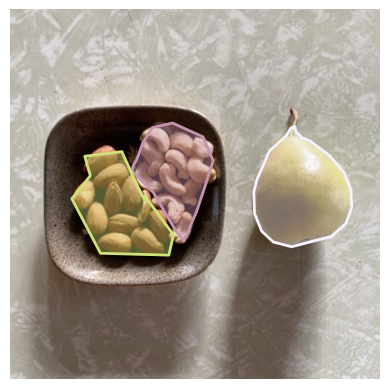

In [13]:
img_no = 7

annIds = train_coco.getAnnIds(imgIds=train_annotations_data['images'][img_no]['id'])
anns = train_coco.loadAnns(annIds)

# load and render the image
plt.imshow(plt.imread(TRAIN_IMAGE_DIRECTIORY+train_annotations_data['images'][img_no]['file_name']))
plt.axis('off')
# Render annotations on top of the image
train_coco.showAnns(anns)

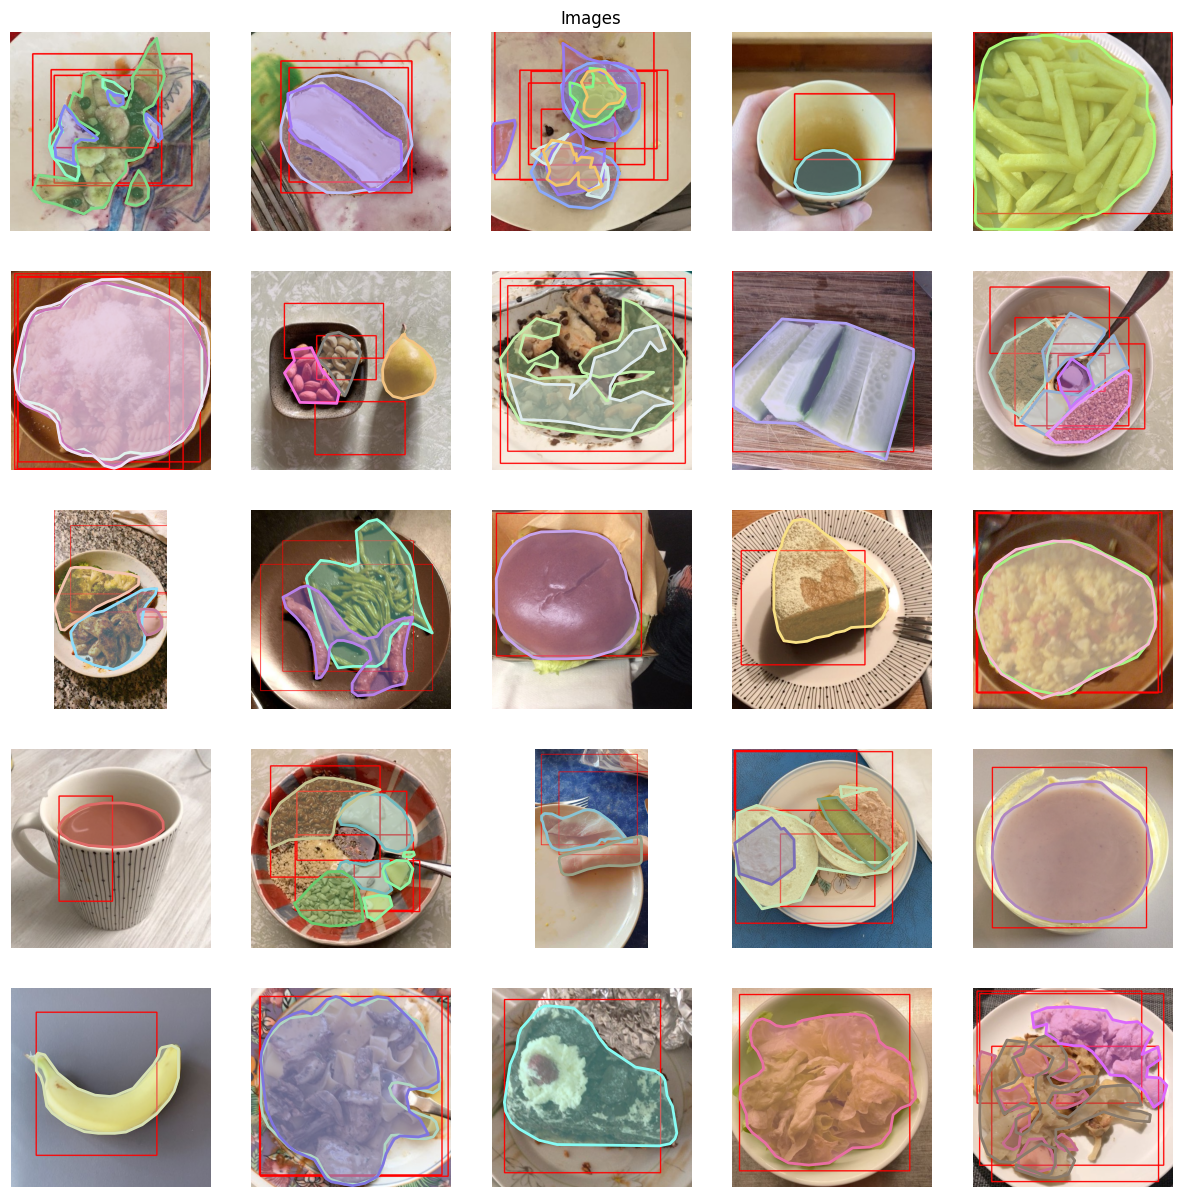

In [14]:
w, h = 15, 15 # Setting width and height of every image
rows, cols = 5, 5 # Setting the number of image rows & cols

fig = plt.figure(figsize=(15, 15)) # Making the figure with size 

plt.title("Images") 
plt.axis('off')

# Going thought every cell in rows and cols
for i in range(1, cols * rows + 1):
  annIds = train_coco.getAnnIds(imgIds=img_info['id'][i])
  anns = train_coco.loadAnns(annIds)

  fig.add_subplot(rows, cols, i)

  # Read the image and make a writable copy
  img = plt.imread(TRAIN_IMAGE_DIRECTIORY + img_info['file_name'][i])
  img = np.copy(img)  # Make a writable copy

  for ann in anns:
      [x, y, w, h] = ann['bbox']
      # Draw the rectangle on the image
      cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)

  plt.imshow(img)
  train_coco.showAnns(anns)
  plt.axis("off")


# Showing the figure
plt.show()

## Fixing the data

In [15]:
np.array(train_annotations_data['annotations'][n]['segmentation']).shape , np.array(train_annotations_data['annotations'][n]['bbox']).shape

((1, 38), (4,))

In [16]:
from tqdm import tqdm

# Function for taking a annotation & directiory of images and returning new annoation json with fixed image size info
def fix_data(annotations, directiory):
  for n, i in enumerate(tqdm((annotations['images']))):
   
      img = cv2.imread(directiory+i["file_name"])
 
      if img.shape[0] != i['height']:
          annotations['images'][n]['height'] = img.shape[0]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

  return annotations

train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTIORY)

with open('../bigdata/train/new_ann.json', 'w') as f:
    json.dump(train_annotations_data, f)

  4%|▍         | 1752/39962 [00:02<00:44, 851.94it/s]

008618.jpg
{'id': 8618, 'file_name': '008618.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008618.jpg
{'id': 8618, 'file_name': '008618.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008619.jpg
{'id': 8619, 'file_name': '008619.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008619.jpg
{'id': 8619, 'file_name': '008619.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008620.jpg
{'id': 8620, 'file_name': '008620.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008620.jpg
{'id': 8620, 'file_name': '008620.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008621.jpg
{'id': 8621, 'file_name': '008621.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008621.jpg
{'id': 8621, 'file_name': '008621.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008626.jpg
{'id': 8626, 'file_name': '008626.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008626.jpg
{'id': 8626, 'file_name': '008626.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008627.jpg
{'id': 86

  5%|▍         | 1838/39962 [00:02<01:51, 342.01it/s]

008628.jpg
{'id': 8628, 'file_name': '008628.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008628.jpg
{'id': 8628, 'file_name': '008628.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  5%|▍         | 1902/39962 [00:02<01:46, 357.99it/s]

008817.jpg
{'id': 8817, 'file_name': '008817.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008817.jpg
{'id': 8817, 'file_name': '008817.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008864.jpg
{'id': 8864, 'file_name': '008864.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008864.jpg
{'id': 8864, 'file_name': '008864.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008869.jpg
{'id': 8869, 'file_name': '008869.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008869.jpg
{'id': 8869, 'file_name': '008869.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  5%|▌         | 2006/39962 [00:03<02:08, 296.01it/s]

008919.jpg
{'id': 8919, 'file_name': '008919.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008919.jpg
{'id': 8919, 'file_name': '008919.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008934.jpg
{'id': 8934, 'file_name': '008934.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008934.jpg
{'id': 8934, 'file_name': '008934.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  9%|▉         | 3550/39962 [00:05<00:55, 659.31it/s]

011967.jpg
{'id': 11967, 'file_name': '011967.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
011967.jpg
{'id': 11967, 'file_name': '011967.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
012045.jpg
{'id': 12045, 'file_name': '012045.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
012045.jpg
{'id': 12045, 'file_name': '012045.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


 11%|█         | 4373/39962 [00:06<00:53, 663.04it/s]

013989.jpg
{'id': 13989, 'file_name': '013989.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
013989.jpg
{'id': 13989, 'file_name': '013989.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


 15%|█▍        | 5865/39962 [00:08<00:57, 588.51it/s]

017312.jpg
{'id': 17312, 'file_name': '017312.jpg', 'width': 3264, 'height': 3264} (3264, 2448, 3)
017312.jpg
{'id': 17312, 'file_name': '017312.jpg', 'width': 2448, 'height': 3264} (3264, 2448, 3)


 20%|█▉        | 7953/39962 [00:11<00:51, 616.53it/s]

021923.jpg
{'id': 21923, 'file_name': '021923.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
021923.jpg
{'id': 21923, 'file_name': '021923.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 21%|██        | 8447/39962 [00:12<00:51, 611.79it/s]

023295.jpg
{'id': 23295, 'file_name': '023295.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023295.jpg
{'id': 23295, 'file_name': '023295.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)
023296.jpg
{'id': 23296, 'file_name': '023296.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023296.jpg
{'id': 23296, 'file_name': '023296.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 22%|██▏       | 8743/39962 [00:12<00:55, 566.33it/s]

023975.jpg
{'id': 23975, 'file_name': '023975.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023975.jpg
{'id': 23975, 'file_name': '023975.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)
023976.jpg
{'id': 23976, 'file_name': '023976.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023976.jpg
{'id': 23976, 'file_name': '023976.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 50%|█████     | 20161/39962 [00:30<00:52, 380.23it/s]

049396.jpg
{'id': 49396, 'file_name': '049396.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
049396.jpg
{'id': 49396, 'file_name': '049396.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


 51%|█████▏    | 20549/39962 [00:31<00:45, 427.66it/s]

050167.jpg
{'id': 50167, 'file_name': '050167.jpg', 'width': 4032, 'height': 4032} (4032, 1960, 3)
050167.jpg
{'id': 50167, 'file_name': '050167.jpg', 'width': 1960, 'height': 4032} (4032, 1960, 3)


 55%|█████▌    | 22169/39962 [00:35<01:08, 259.81it/s]

053873.jpg
{'id': 53873, 'file_name': '053873.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
053873.jpg
{'id': 53873, 'file_name': '053873.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)
053875.jpg
{'id': 53875, 'file_name': '053875.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
053875.jpg
{'id': 53875, 'file_name': '053875.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)
053879.jpg
{'id': 53879, 'file_name': '053879.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
053879.jpg
{'id': 53879, 'file_name': '053879.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


 57%|█████▋    | 22653/39962 [00:36<00:44, 388.07it/s]

056091.jpg
{'id': 56091, 'file_name': '056091.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
056091.jpg
{'id': 56091, 'file_name': '056091.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


100%|██████████| 39962/39962 [00:59<00:00, 670.02it/s] 


In [18]:
def fix_data_val(annotations, directiory):
  for n, i in enumerate(tqdm((annotations['images']))):
      img = cv2.imread(directiory+i["file_name"])
      if img.shape[0] != i['height']:
          print(n)
          annotations['images'][n]['height'] = img.shape[0]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

  return annotations

val_annotations_data = fix_data_val(val_annotations_data, VAL_IMAGE_DIRECTIORY)

with open('../bigdata/val/new_ann.json', 'w') as f:
    json.dump(val_annotations_data, f)

100%|██████████| 1000/1000 [00:01<00:00, 692.71it/s]


In [19]:
dict_addres = val_annotations_data['images'][748]
plt.imread(VAL_IMAGE_DIRECTIORY+dict_addres['file_name']).shape[:2], (dict_addres['height'], dict_addres['width'])

((918, 919), (918, 919))